In [1]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(
  ["git", "clone", REPO_URL, str(REPO_DIR)],
  check=True
)

USE_CLEAN = False  # <--- Set True to remove existing environment
opts = "--clean" if USE_CLEAN else ""

get_ipython().run_line_magic(
    "run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts}"
)

⚠️ Google Drive not mounted — using local cache (/content)
🔧 Installing FEniCSx environment...
✨ Loading FEniCSx Jupyter magic... %%fenicsx registered


---

In [2]:
%%fenicsx

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import basix

n = 30
x = np.linspace(0, 1, n)
points = np.array(
    [[xi, eta] for xi in x
               for eta in x if xi + eta <= 1]
)

element = basix.create_element(
    basix.ElementFamily.P,
    basix.CellType.triangle,
    degree=1
)

values = element.tabulate(0, points)
basis = values[0, :, :, 0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

tri = Triangulation(points[:, 0], points[:, 1])

for i in range(3):
    tpc = axes[i].tripcolor(
        tri, basis[:, i], shading="gouraud"
    )
    axes[i].set_title(f"P1 basis $\\phi_{i}$")
    axes[i].set_aspect("equal")

cbar = fig.colorbar(
    tpc,
    ax=axes,
    orientation="horizontal",
    fraction=0.05,
    pad=0.15
)

cbar.set_label("Basis function value")

plt.savefig("P1_basis.png", dpi=300)

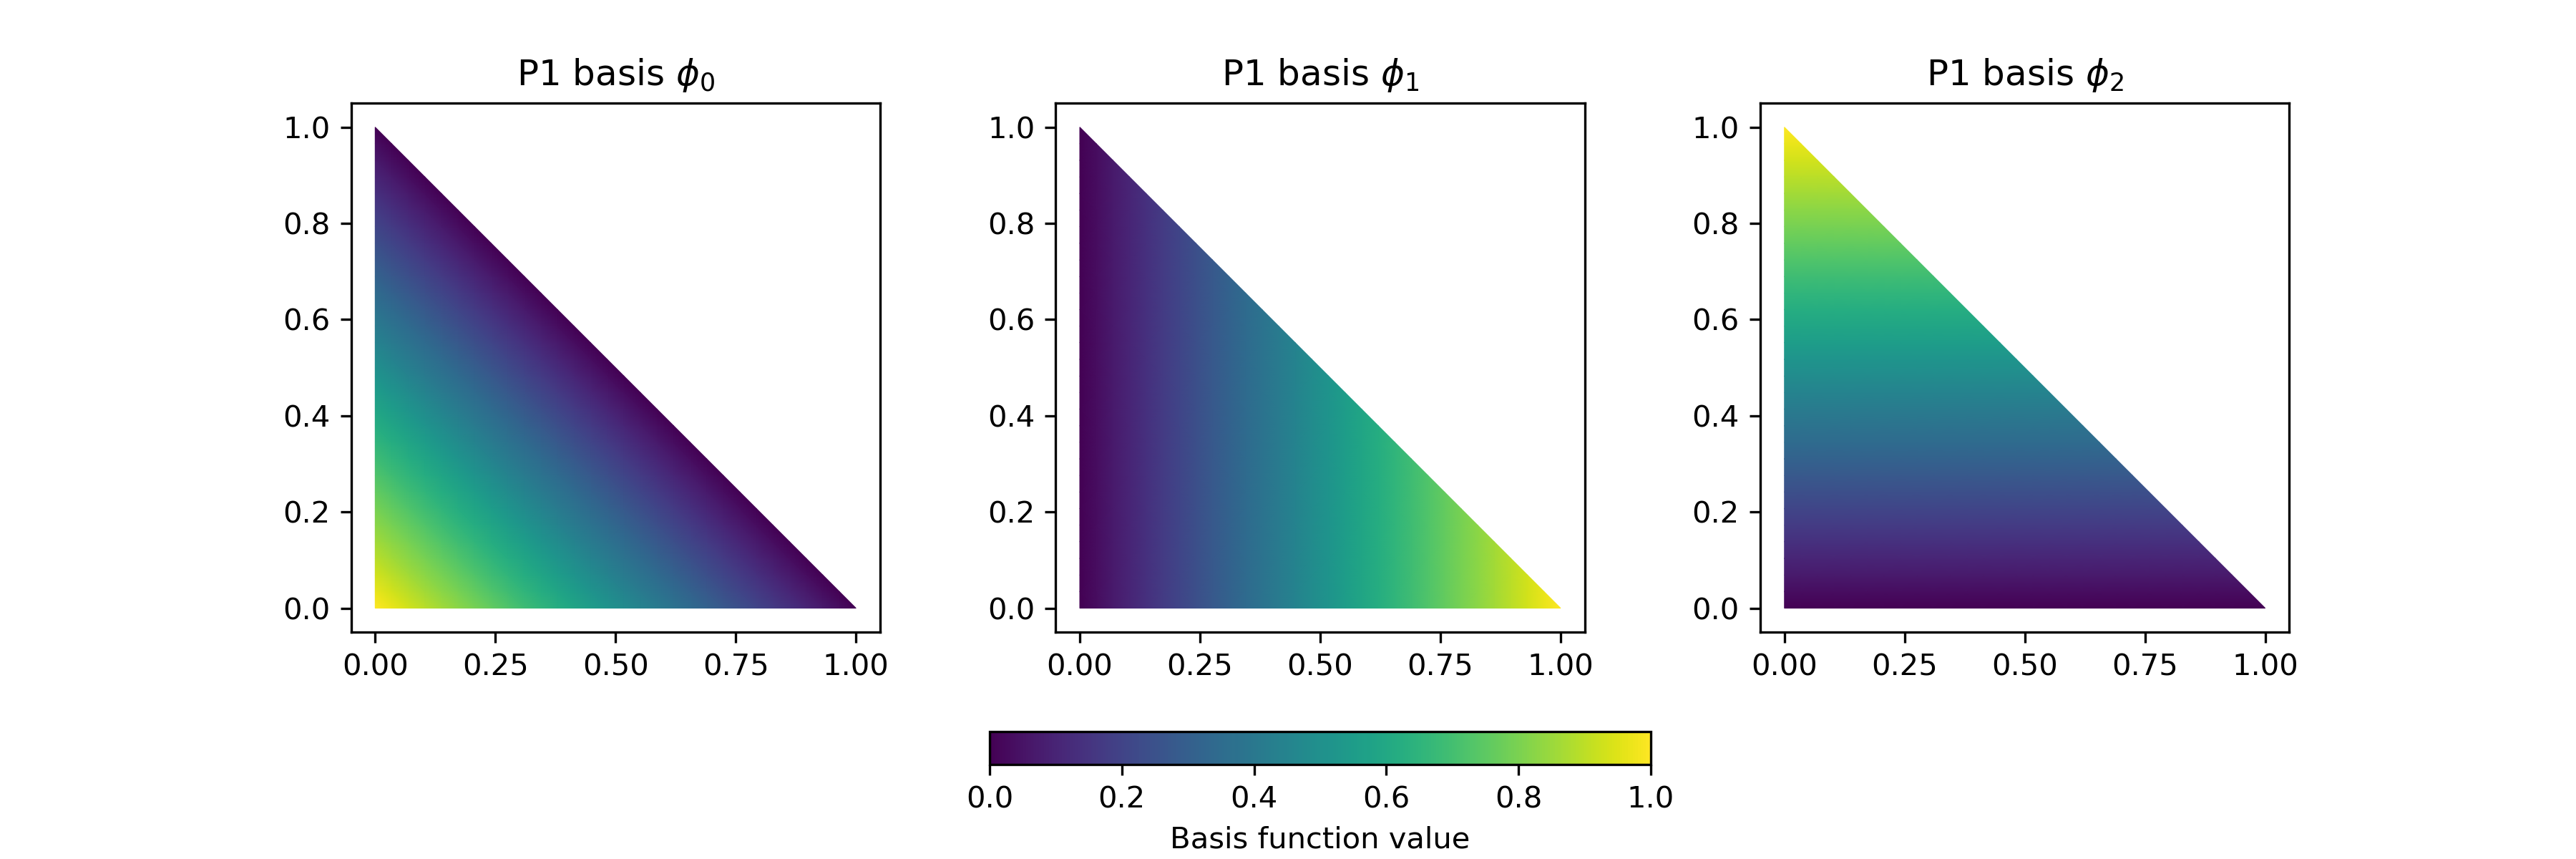

In [3]:
from IPython.display import Image, display

display(Image(filename='P1_basis.png'))

In [4]:
%%fenicsx

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import basix

element = basix.create_element(
    basix.ElementFamily.RT,
    basix.CellType.triangle,
    degree=1
)

# --------------------------------------------------------

n_basis = element.dim
print("Number of RT basis functions:", n_basis)

edges = [
    (np.array([1.0, 0.0]), np.array([0.0, 1.0])),  # e0
    (np.array([0.0, 1.0]), np.array([0.0, 0.0])),  # e1
    (np.array([0.0, 0.0]), np.array([1.0, 0.0]))   # e2
]

normals = [
    np.array([1.0, 1.0]),    # e0
    np.array([-1.0, 0.0]),   # e1
    np.array([0.0, -1.0])    # e2
]

def edge_flux(basis_index, edge, normal, npts=50):
    a, b = edge
    s = np.linspace(0, 1, npts)

    # Edge points
    points = (1 - s)[:, None] * a + s[:, None] * b

    # Unit normal
    n_hat = normal / np.linalg.norm(normal)

    # Evaluate basis
    tab = element.tabulate(0, points)
    phi = tab[0, :, basis_index, :]  # (npts, 2)

    # Flux integral
    integrand = phi @ n_hat
    edge_length = np.linalg.norm(b - a)
    return np.trapezoid(integrand, s) * edge_length

fluxes = np.zeros((n_basis, 3))

for i in range(n_basis):
    for j in range(3):
        fluxes[i, j] = edge_flux(i, edges[j], normals[j])

clean = fluxes.copy()
clean[np.abs(clean) < 1e-12] = 0

print("Edge flux integrals ∫_e phi_i · n ds:")
print(clean)

# --------------------------------------------------------

n = 10
x = np.linspace(0, 1, n)
points = np.array(
    [[xi, eta] for xi in x
               for eta in x if xi + eta <= 1]
)

values = element.tabulate(0, points)
rt_basis = values[0]

fig, axes = plt.subplots(
    1, rt_basis.shape[1],
    figsize=(12, 4),
    constrained_layout=True
)

for i in range(rt_basis.shape[1]):
    ax = axes[i]
    ax.quiver(
        points[:, 0], points[:, 1],
        rt_basis[:, i, 0], rt_basis[:, i, 1]
    )
    ax.set_title(f"RT basis {i}")
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.savefig("RT_basis.png", dpi=300)

# --------------------------------------------------------

N = 40
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)

X, Y = np.meshgrid(x, y)
mask = (X + Y <= 1.0)

points = np.vstack([X[mask], Y[mask]]).T

# Tabulate first derivatives
tab = element.tabulate(1, points)

# Indexing helpers
# 0: value
# 1: d/dx
# 2: d/dy

fig, axes = plt.subplots(1, n_basis, figsize=(12, 4), constrained_layout=True)

for i in range(n_basis):
    du_dx = tab[1, :, i, :]
    du_dy = tab[2, :, i, :]

    div = du_dx[:, 0] + du_dy[:, 1]

    # Put div values back on grid
    Z = np.full_like(X, np.nan, dtype=float)
    Z[mask] = div

    ax = axes[i]
    im = ax.pcolormesh(X, Y, Z, shading="auto", cmap="RdBu")
    ax.set_title(f"div(RT basis {i})")
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Reference triangle
    ax.plot([0, 1, 0, 0], [0, 0, 1, 0], "k-", lw=1)

plt.savefig("RT_basis_div.png", dpi=300)

Number of RT basis functions: 3
Edge flux integrals ∫_e phi_i · n ds:
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]


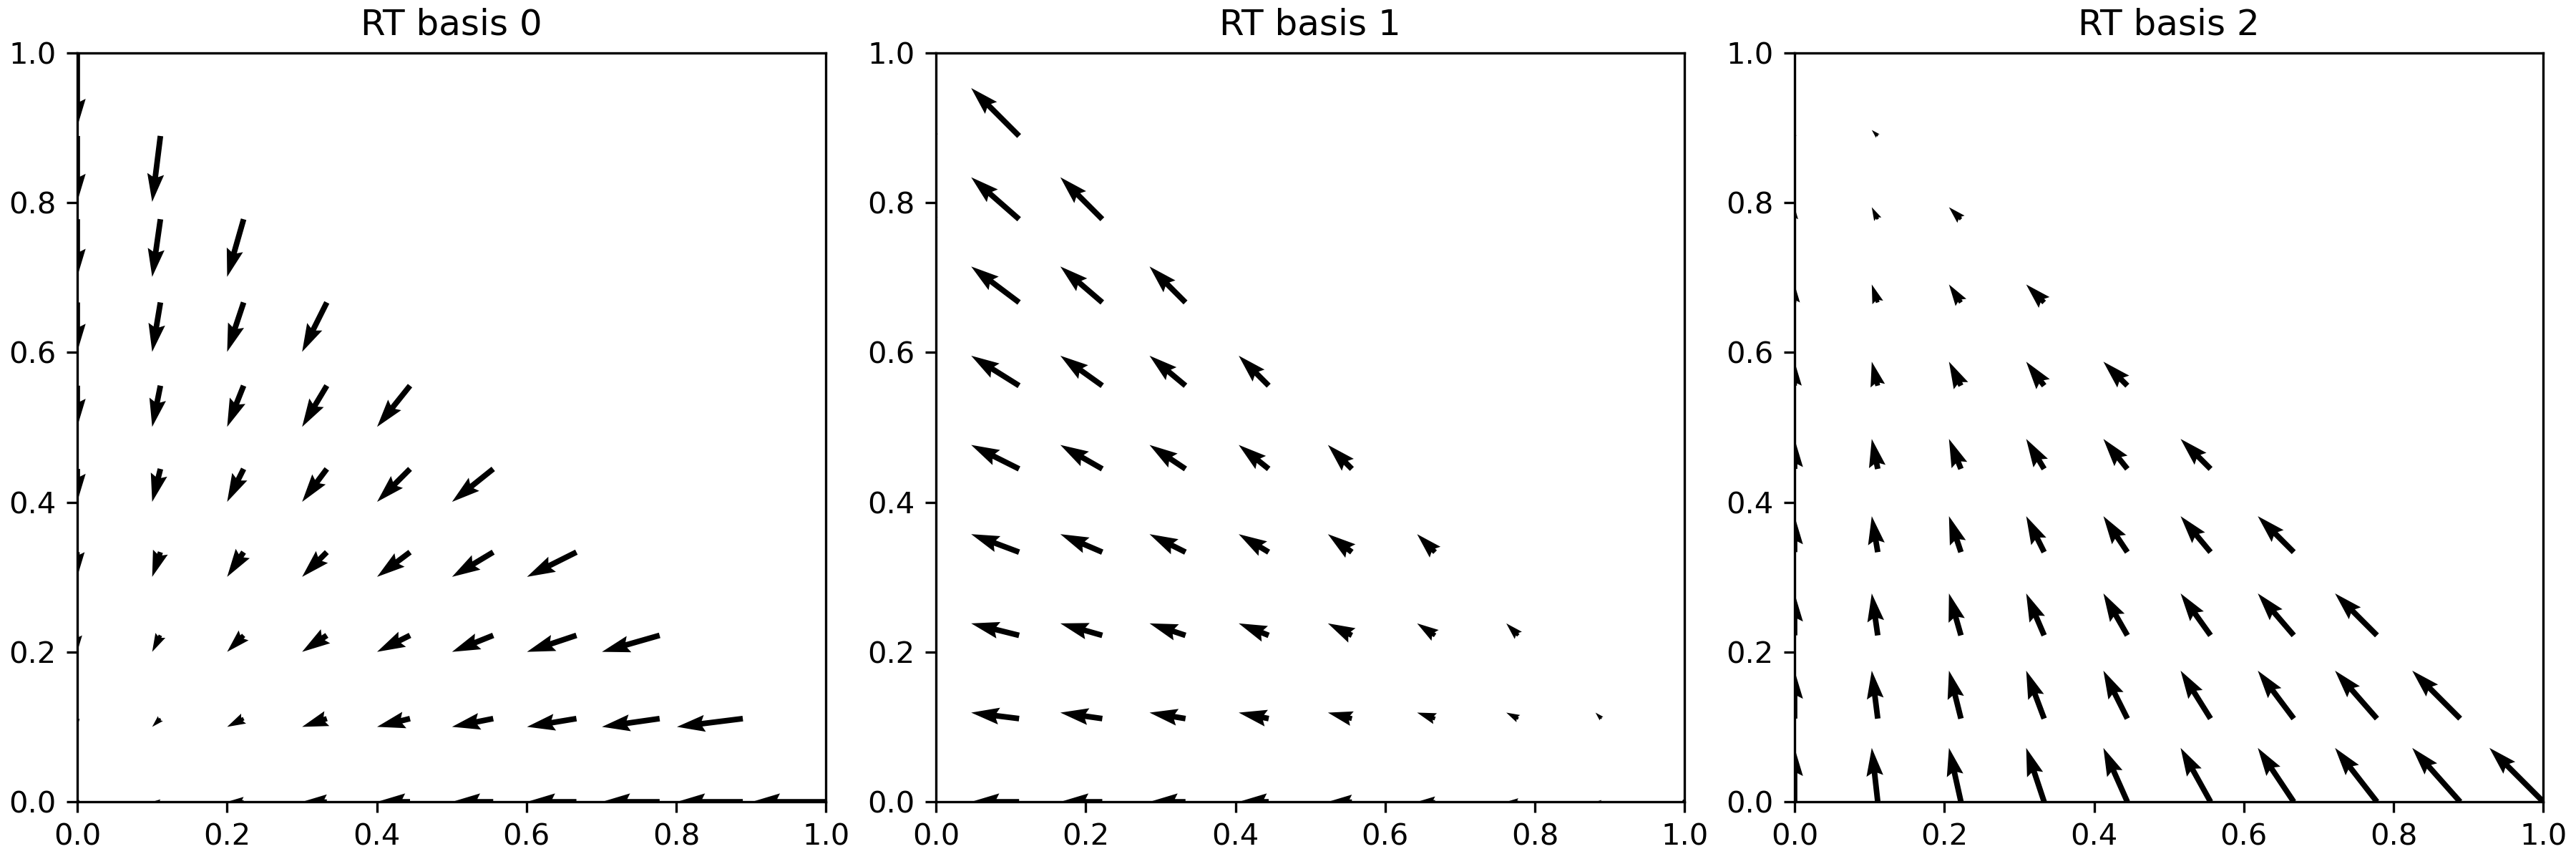

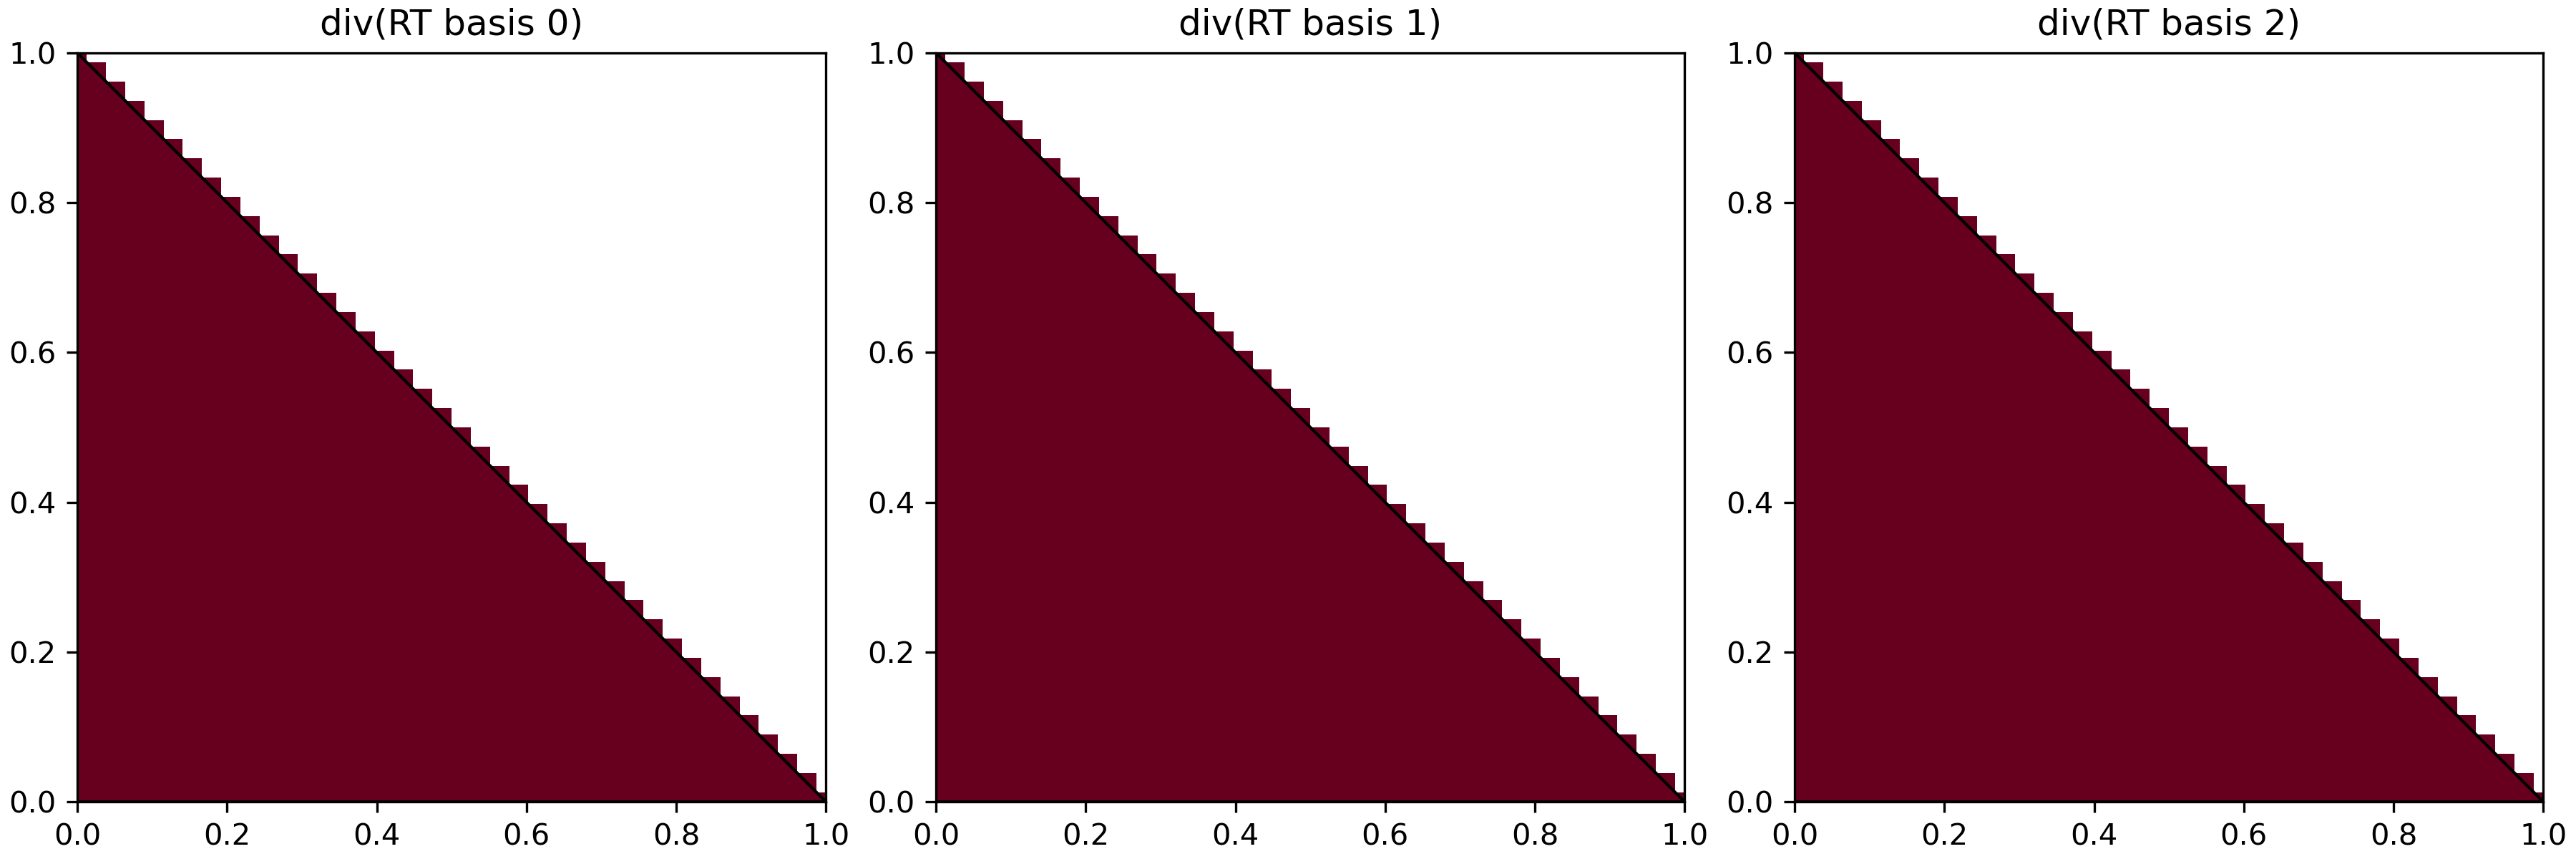

In [5]:
display(Image(filename='RT_basis.png'))
display(Image(filename='RT_basis_div.png'))

In [6]:
%%fenicsx

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import basix

element = basix.create_element(
    basix.ElementFamily.N1E,
    basix.CellType.triangle,
    degree=1
)

# --------------------------------------------------------

n_basis = element.dim
print("Number of Nédélec basis functions:", n_basis)

edges = [
    (np.array([1.0, 0.0]), np.array([0.0, 1.0])),  # e0
    (np.array([0.0, 1.0]), np.array([0.0, 0.0])),  # e1
    (np.array([0.0, 0.0]), np.array([1.0, 0.0]))   # e2
]

def edge_integral(basis_index, edge, npts=50):
    a, b = edge
    s = np.linspace(0, 1, npts)

    # Parametric edge points
    points = (1 - s)[:, None] * a + s[:, None] * b

    # Tangent vector (constant on straight edge)
    t = b - a
    edge_length = np.linalg.norm(t)
    t_hat = t / edge_length

    # Evaluate basis
    values = element.tabulate(0, points)
    phi = values[0, :, basis_index, :]  # (npts, 2)

    # Line integral
    integrand = phi @ t_hat
    return np.trapezoid(integrand, s) * edge_length

integrals = np.zeros((n_basis, 3))

for i in range(n_basis):
    for j, edge in enumerate(edges):
        integrals[i, j] = edge_integral(i, edge)

clean = integrals.copy()
clean[np.abs(clean) < 1e-12] = 0

print("\nEdge integrals ∫_e phi_i · t ds:")
print(clean)

# --------------------------------------------------------

n = 10
x = np.linspace(0, 1, n)
points = np.array(
    [[xi, eta] for xi in x
               for eta in x if xi + eta <= 1]
)

values = element.tabulate(0, points)
ned_basis = values[0]

fig, axes = plt.subplots(
    1, ned_basis.shape[1],
    figsize=(12, 4),
    constrained_layout=True
)

for i in range(ned_basis.shape[1]):
    ax = axes[i]
    ax.quiver(
        points[:, 0], points[:, 1],
        ned_basis[:, i, 0], ned_basis[:, i, 1]
    )
    ax.set_title(f"Nédélec basis {i}")
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.savefig("N1E_basis.png", dpi=300)

# --------------------------------------------------------

N = 40
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)

X, Y = np.meshgrid(x, y)
mask = (X + Y <= 1.0)

points = np.vstack([X[mask], Y[mask]]).T

# Tabulate first derivatives
tab = element.tabulate(1, points)

# Indexing helpers
# 0: value
# 1: d/dx
# 2: d/dy

fig, axes = plt.subplots(1, n_basis, figsize=(12, 4), constrained_layout=True)

for i in range(n_basis):
    # u = (u_x, u_y)
    du_dx = tab[1, :, i, :]
    du_dy = tab[2, :, i, :]

    curl = du_dx[:, 1] - du_dy[:, 0]

    # Put curl values back on grid
    Z = np.full_like(X, np.nan, dtype=float)
    Z[mask] = curl

    ax = axes[i]
    im = ax.pcolormesh(X, Y, Z, shading="auto", cmap="RdBu")
    ax.set_title(f"curl(Nédélec basis {i})")
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Reference triangle
    ax.plot([0, 1, 0, 0], [0, 0, 1, 0], "k-", lw=1)

plt.savefig("N1E_basis_curl.png", dpi=300)

Number of Nédélec basis functions: 3

Edge integrals ∫_e phi_i · t ds:
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]


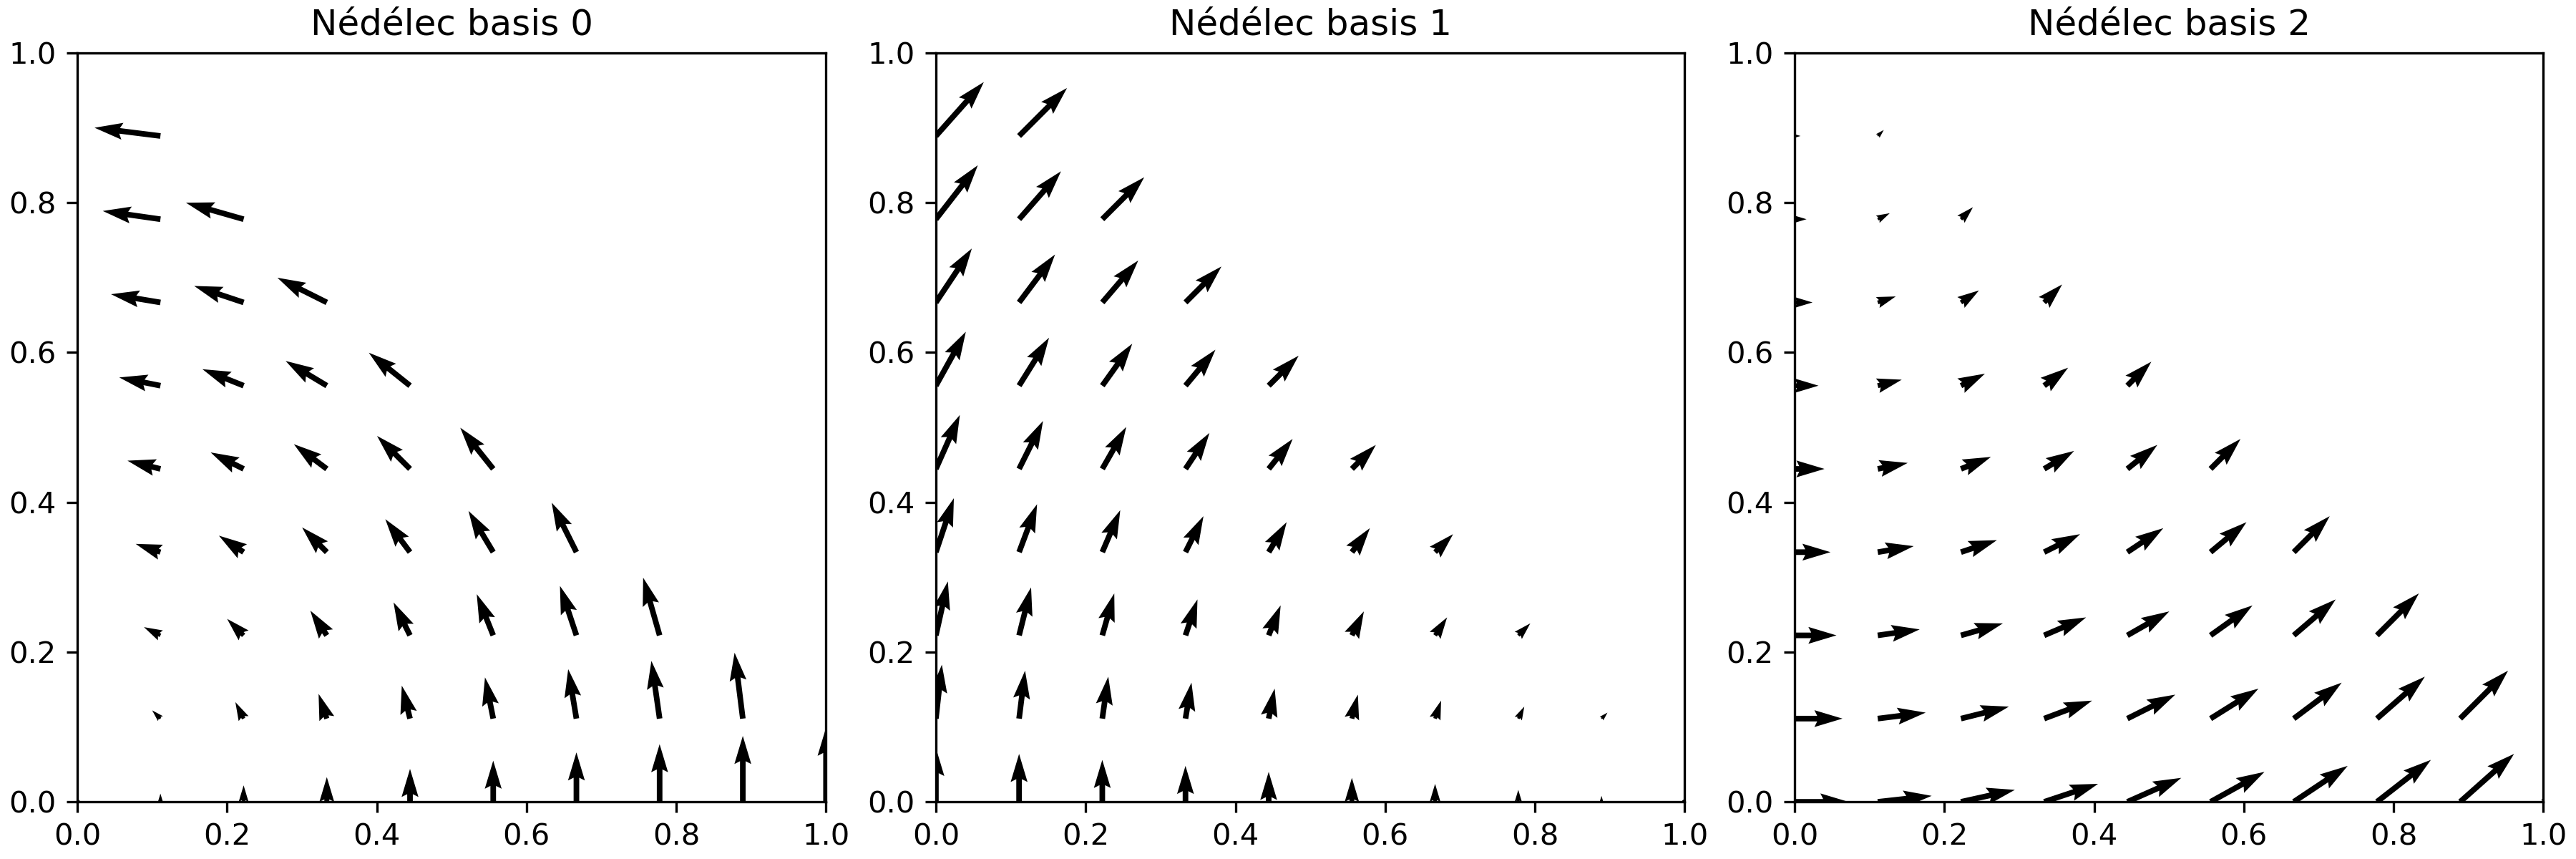

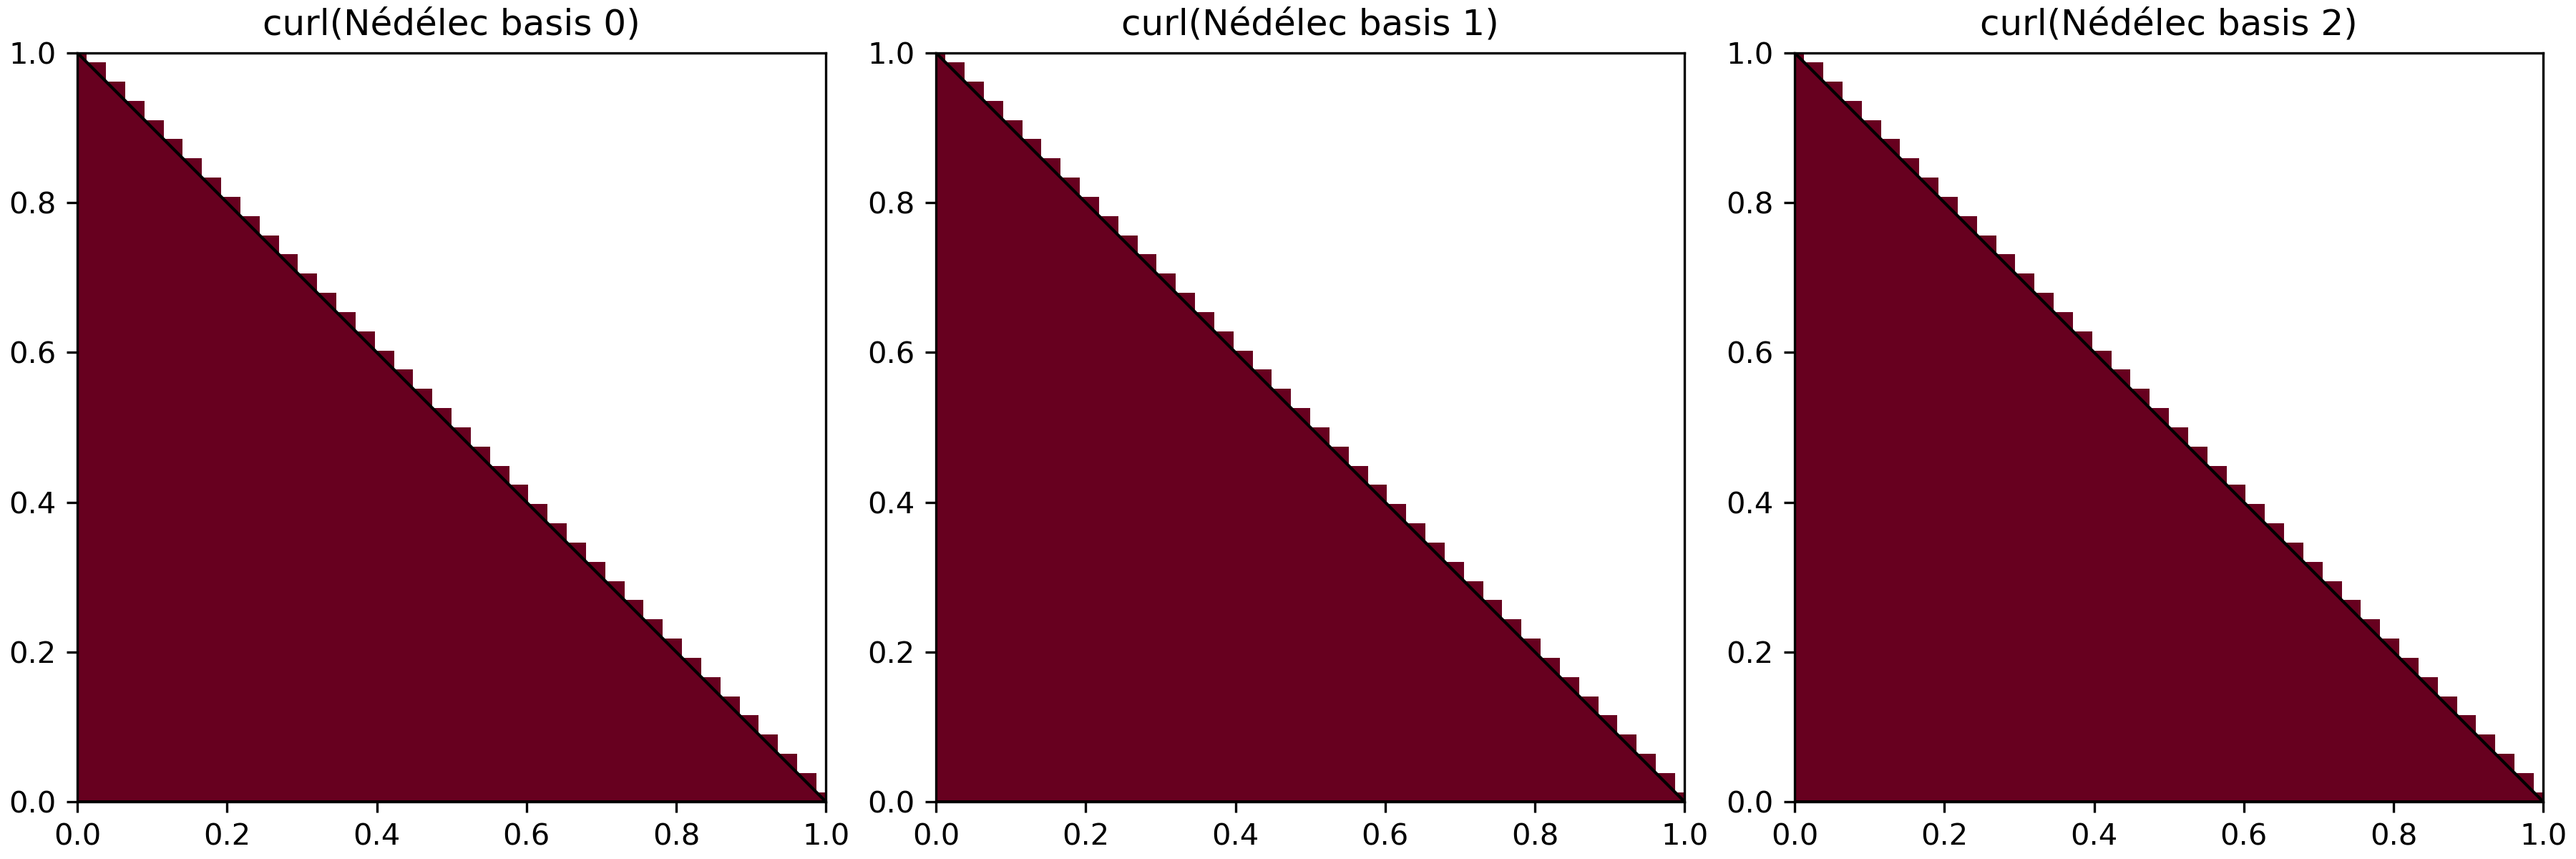

In [7]:
display(Image(filename='N1E_basis.png'))

display(Image(filename='N1E_basis_curl.png'))

---

In [8]:
%%fenicsx

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import basix

# --------------------------------------------------------

n = 10
x = np.linspace(0, 1, n)
points = np.array(
    [[xi, eta] for xi in x
               for eta in x if xi + eta <= 1]
)

points_ref = points

A = np.array([[1.2, 0.3],
              [0.2, 0.8]])
b = np.array([0.1, 0.1])

J = np.linalg.det(A)

# --------------------------------------------------------

element = basix.create_element(
    basix.ElementFamily.P,
    basix.CellType.triangle,
    degree=1
)

values = element.tabulate(0, points)
p_basis = values[0]

###
points_phys = (A @ points_ref.T).T + b

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tri = Triangulation(points[:, 0], points[:, 1])

axes[0].tripcolor(
        tri, p_basis[:, 0, 0], shading="gouraud"
)
axes[0].set_title("P1 basis (reference)")
axes[0].set_aspect("equal")

tri = Triangulation(points_phys[:, 0], points_phys[:, 1])

axes[1].tripcolor(
        tri, p_basis[:, 0, 0], shading="gouraud"
)
axes[1].set_title("P1 basis (physical)")
axes[1].set_aspect("equal")

plt.savefig("P1_basis_phys.png", dpi=300)

# --------------------------------------------------------

element = basix.create_element(
    basix.ElementFamily.RT,
    basix.CellType.triangle,
    degree=1
)

values = element.tabulate(0, points)
rt_basis = values[0]

####
rt_phys = (A @ rt_basis.transpose(0, 2, 1)).transpose(0, 2, 1) / J

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].quiver(
    points_ref[:, 0], points_ref[:, 1],
    rt_basis[:, 0, 0], rt_basis[:, 0, 1]
)
axes[0].set_title("RT basis (reference)")
axes[0].set_aspect("equal")

axes[1].quiver(
    points_phys[:, 0], points_phys[:, 1],
    rt_phys[:, 0, 0], rt_phys[:, 0, 1]
)
axes[1].set_title("RT basis (physical)")
axes[1].set_aspect("equal")

plt.savefig("RT_basis_phys.png", dpi=300)

# --------------------------------------------------------

element = basix.create_element(
    basix.ElementFamily.N1E,
    basix.CellType.triangle,
    degree=1
)

values = element.tabulate(0, points)
ned_basis = values[0]

####
ned_phys = (np.linalg.inv(A).T @ ned_basis.transpose(0, 2, 1)).transpose(0, 2, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].quiver(
    points_ref[:, 0], points_ref[:, 1],
    ned_basis[:, 0, 0], ned_basis[:, 0, 1]
)
axes[0].set_title("Nédélec basis (reference)")
axes[0].set_aspect("equal")

axes[1].quiver(
    points_phys[:, 0], points_phys[:, 1],
    ned_phys[:, 0, 0], ned_phys[:, 0, 1]
)
axes[1].set_title("Nédélec basis (physical)")
axes[1].set_aspect("equal")

plt.savefig("N1E_basis_phys.png", dpi=300)


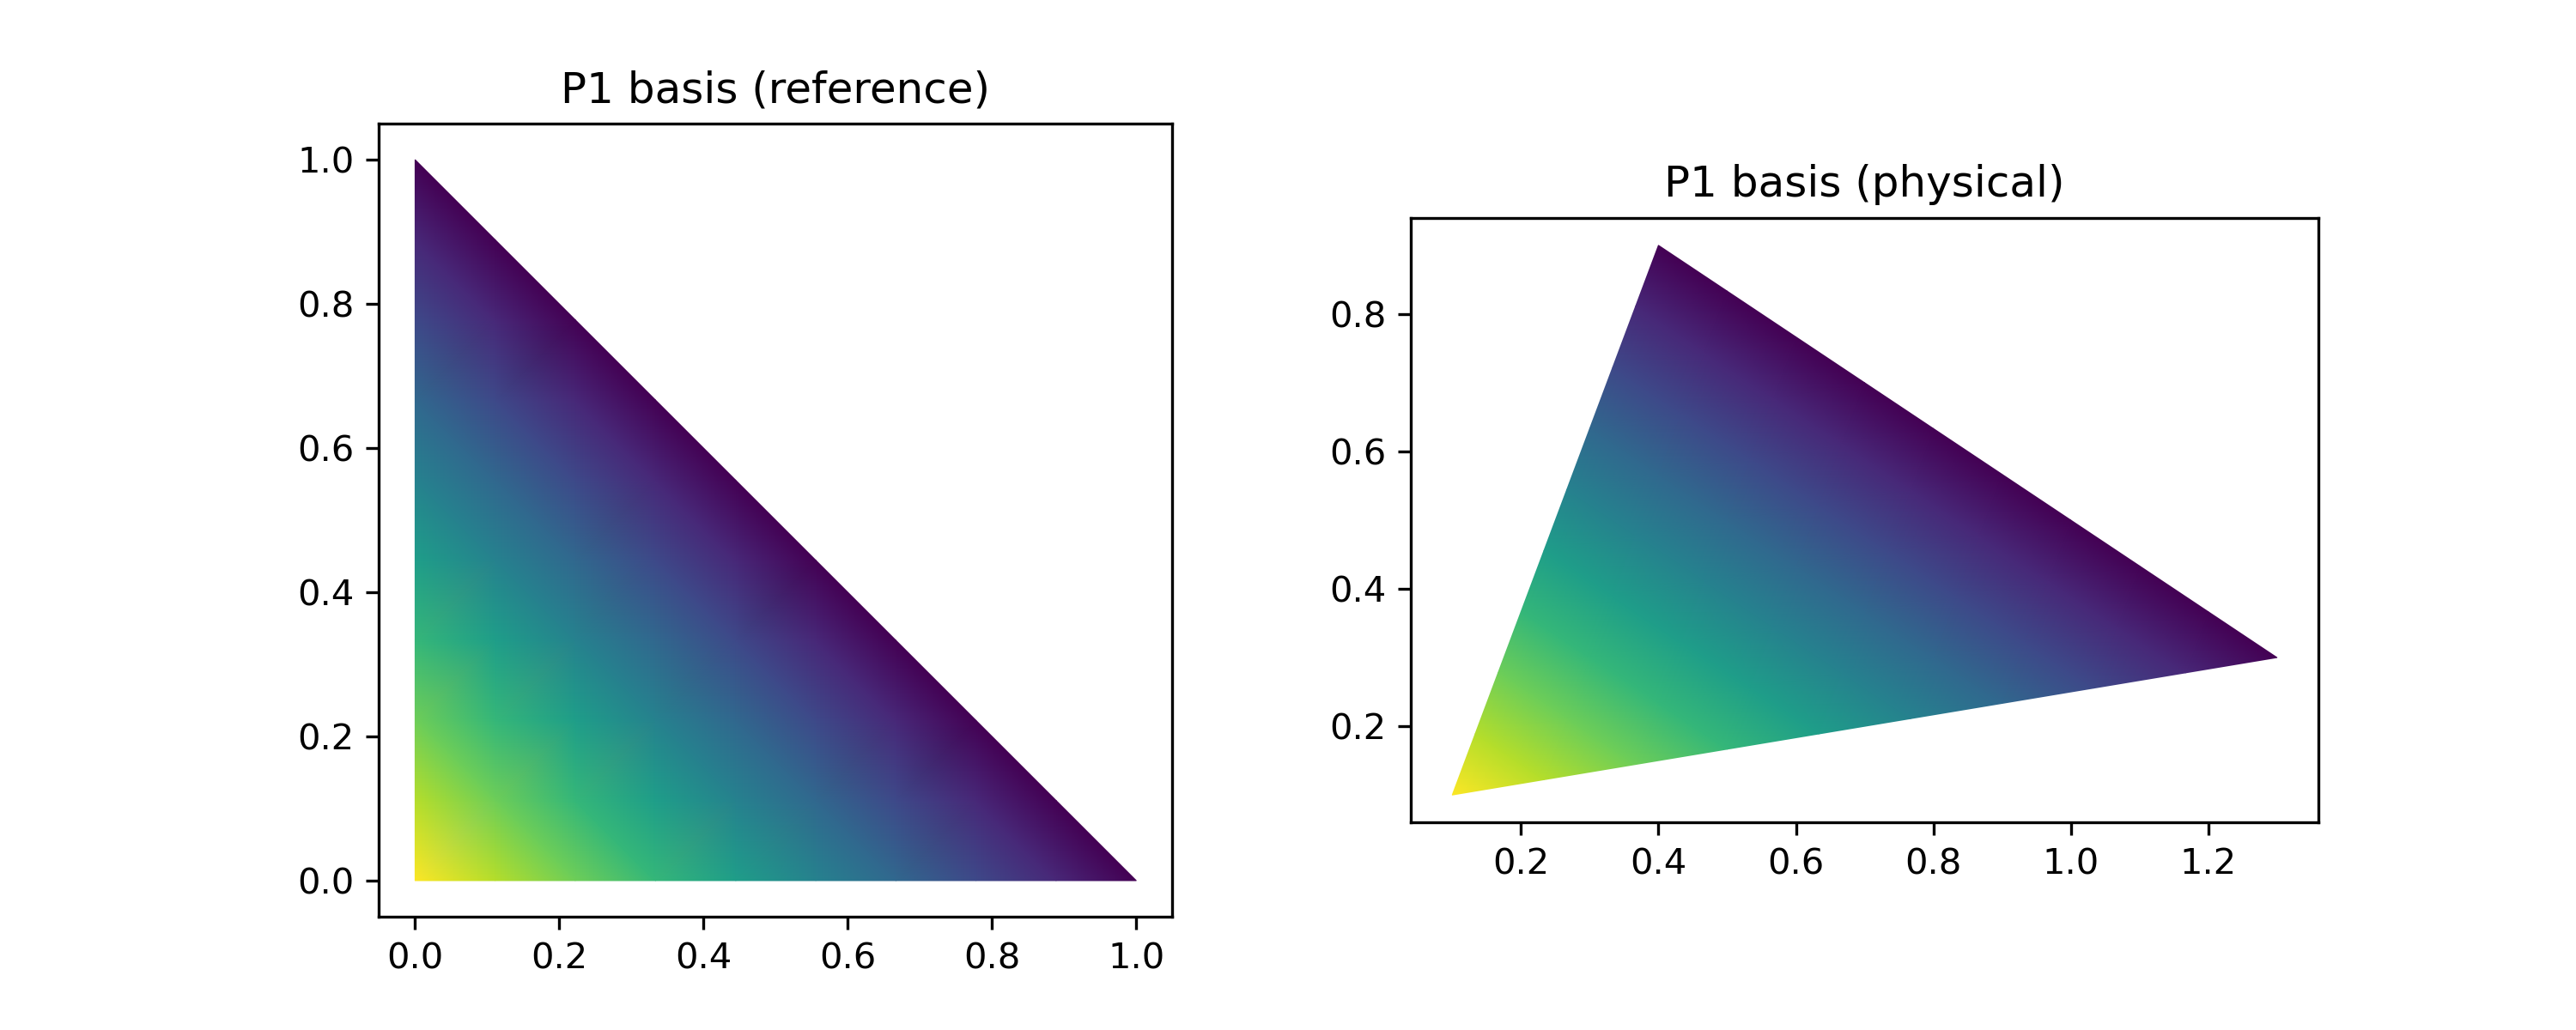

In [9]:
display(Image(filename='P1_basis_phys.png'))

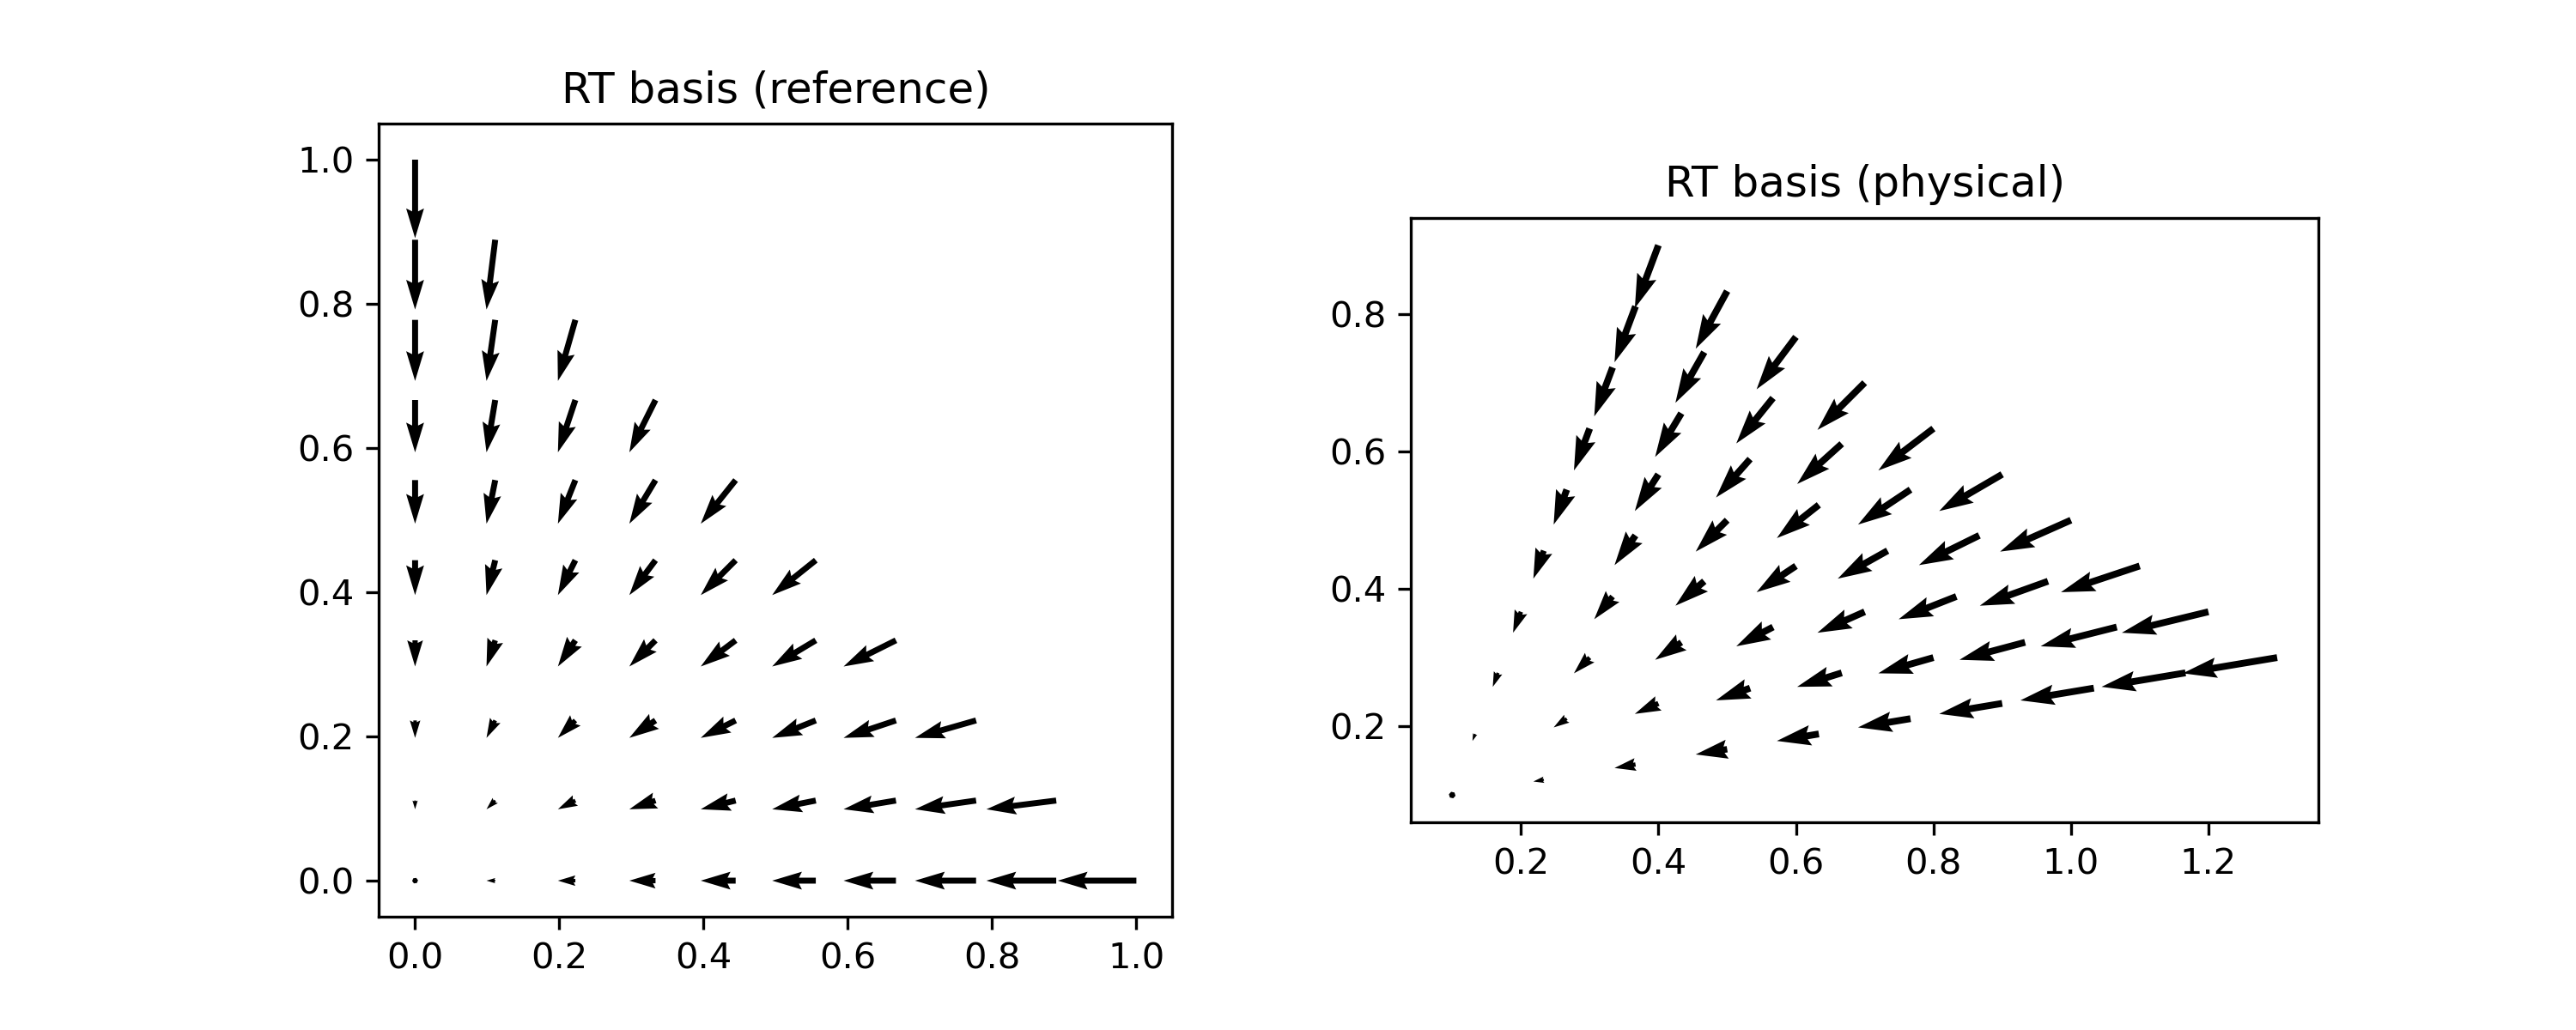

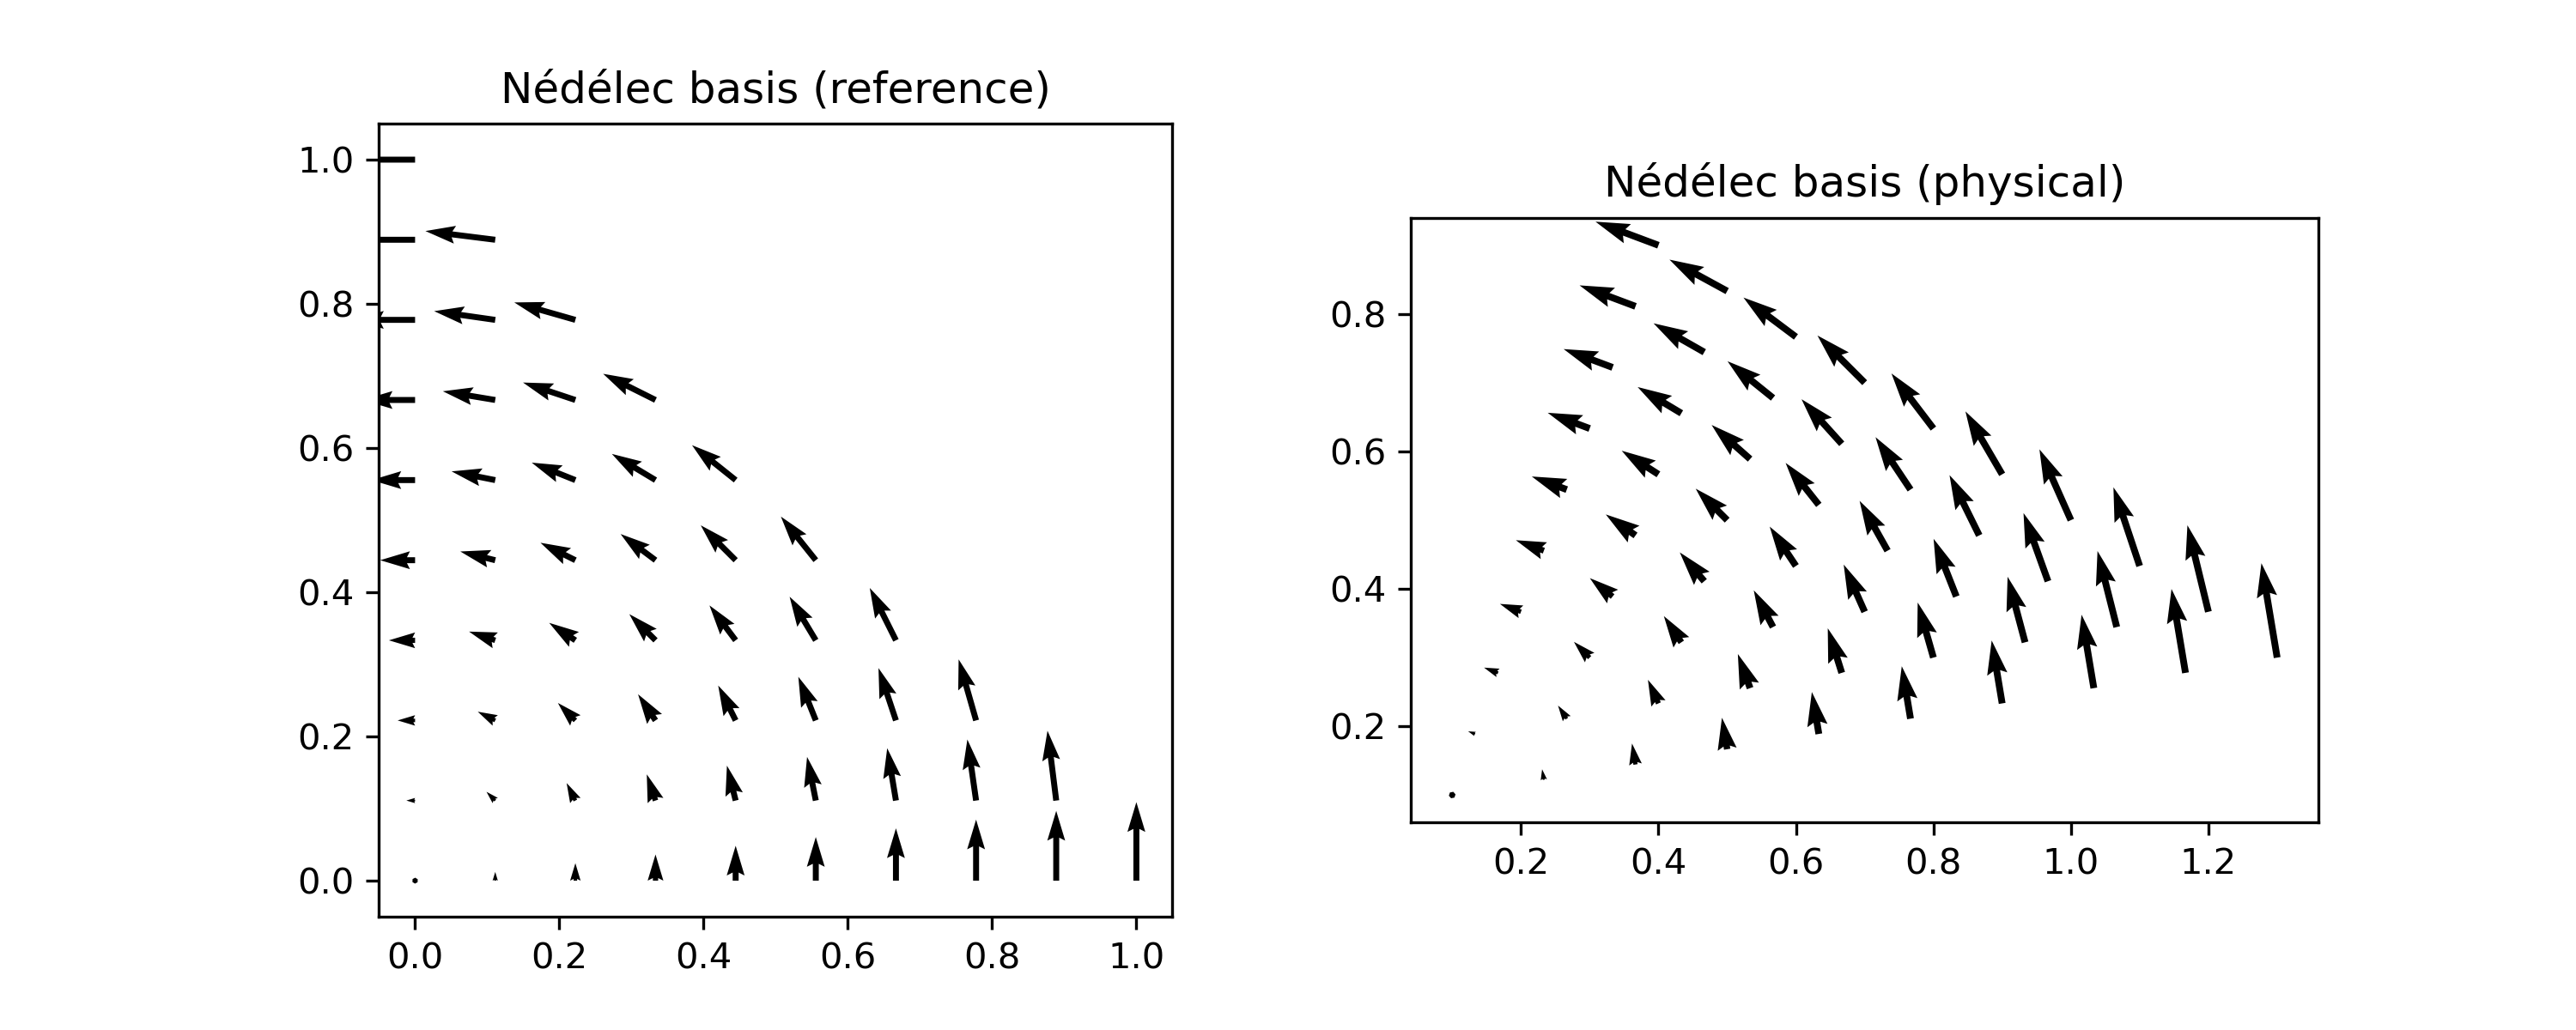

In [10]:
display(Image(filename='RT_basis_phys.png'))
display(Image(filename='N1E_basis_phys.png'))